# Autoregression 

## Parameters

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import os  

from sklearn.metrics import mean_squared_error

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.seasonal import seasonal_decompose

## Data & Plots

In [2]:
def read_dataset():

    url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
    df = pd.read_csv(url)
    df["date"] = pd.to_datetime(df["Month"], format = "%Y-%m")
    df.drop(columns=["Month"], inplace = True)
    df.sort_values(by = ["date"], ascending=True, inplace = True)
    df.reset_index(drop = True, inplace = True)

    return df 

df = read_dataset()
df

,Passengers,date
0,112,1949-01-01
1,118,1949-02-01
2,132,1949-03-01
3,129,1949-04-01
4,121,1949-05-01
...,...,...
139,606,1960-08-01
140,508,1960-09-01
141,461,1960-10-01
142,390,1960-11-01


In [3]:
ts_variable = "Passengers"
date_variable = "date"

In [4]:
# Lest Create the Train and Test Data 
train_size = int(len(df[date_variable])*0.8)
train = df[:train_size].copy()
test = df[train_size:].copy()
train

,Passengers,date
0,112,1949-01-01
1,118,1949-02-01
2,132,1949-03-01
3,129,1949-04-01
4,121,1949-05-01
...,...,...
110,362,1958-03-01
111,348,1958-04-01
112,363,1958-05-01
113,435,1958-06-01


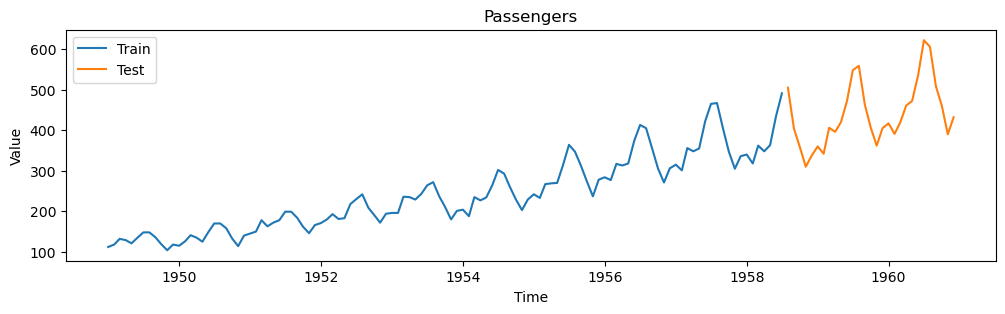

In [5]:
plt.figure(figsize=(12,3))
plt.plot(train[date_variable], train[ts_variable], label = f'Train')
plt.plot(test[date_variable], test[ts_variable], label = f'Test')
plt.title(f"{ts_variable}")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.savefig("img/time_series_train_and_test.png", dpi = 300, bbox_inches='tight')  
plt.show() 

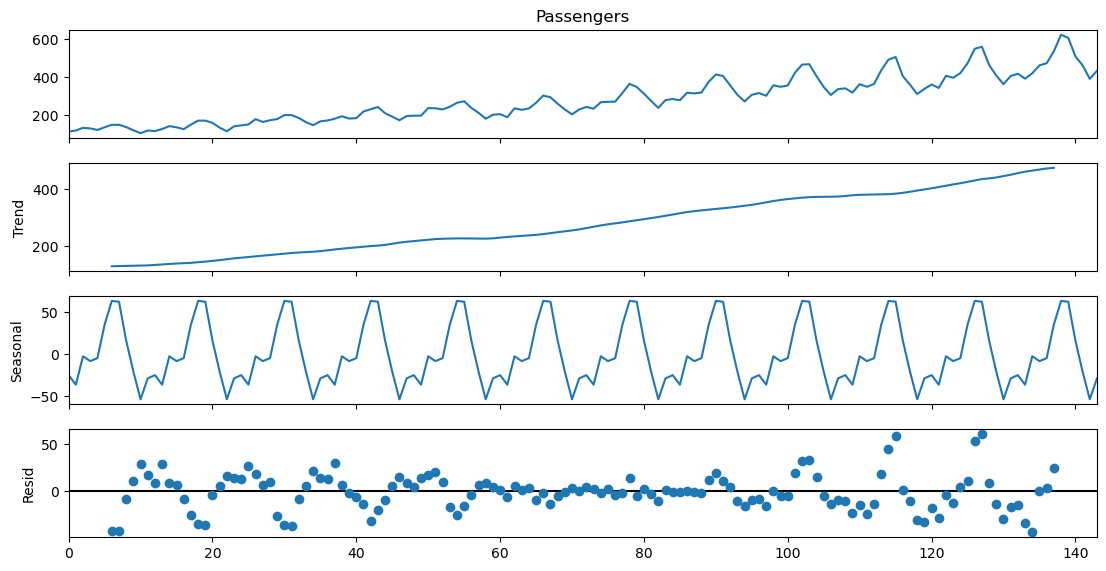

In [6]:
decomp = seasonal_decompose(df[ts_variable], model='additive', period = 12)
fig = decomp.plot()
fig.set_size_inches((12, 6))
plt.show()

## ARIMA(p,d,q) Model

### Determinate $p$ Value -> Partial Autocorrelation Function 


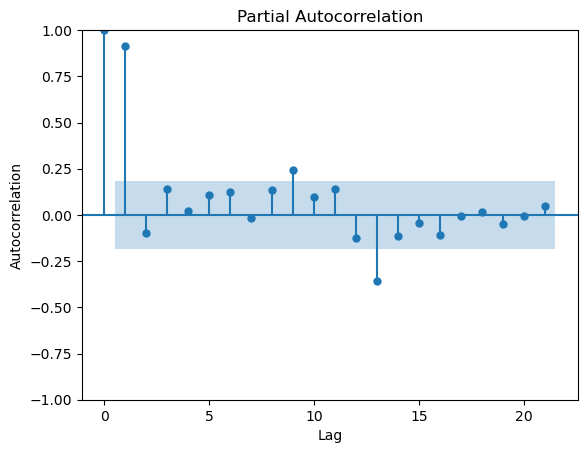

In [7]:
plot_pacf(train[f'{ts_variable}'])
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.savefig("img/partial_autocorrelation.png", dpi = 300, bbox_inches='tight')

The value outside the blue region is $p=13$ and after that, all the others lags are inside the blue region. 

### Determinate $d$ Value -> Augmented Dickey Fuller Test

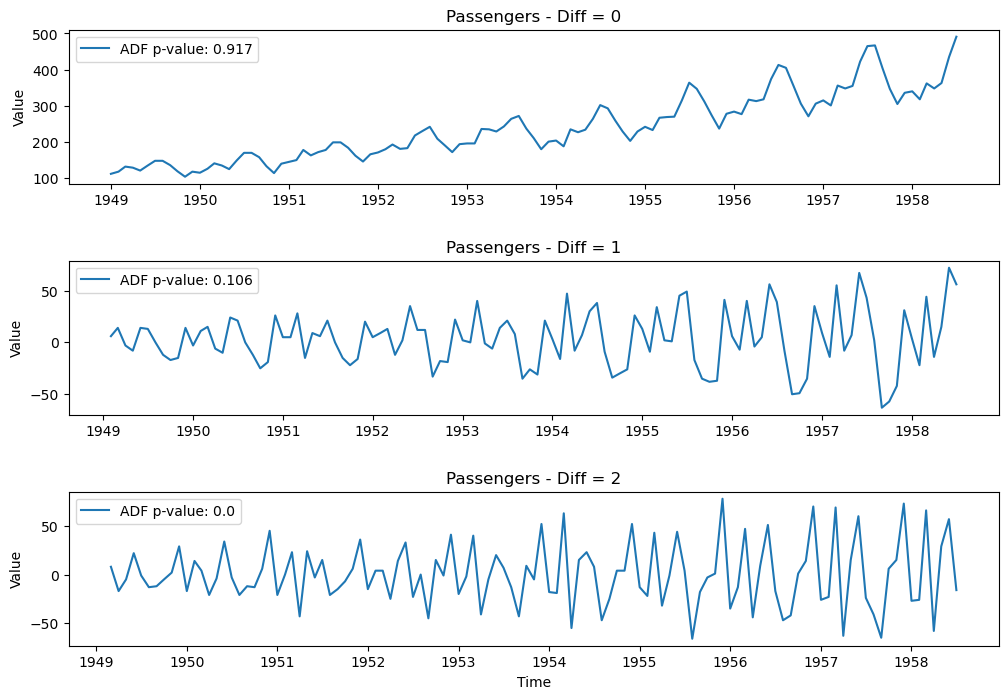

In [8]:
diff_list = [0,1,2]

fig, axs = plt.subplots(len(diff_list), 1, figsize = (12,8))
fig.subplots_adjust(hspace=0.5)

for i in diff_list: 
    
    # Diff
    if i == 0:
        train[f'{ts_variable}_diff_0'] = train[f'{ts_variable}']
    else:
        train[f'{ts_variable}_diff_{i}'] = train[f'{ts_variable}_diff_{i-1}'].diff()

    # Statistical Test - Augmented Dickey-Fulley Test
    result = adfuller(train[f'{ts_variable}_diff_{i}'].dropna())
    adf_statistic = result[0]
    p_value = result[1]

    # Time Series Plot 
    axs[i].plot(train[date_variable], train[f'{ts_variable}_diff_{i}'] , label = f'ADF p-value: {round(p_value, 3)}')
    axs[i].set_title(f"{ts_variable} - Diff = {i}")
    axs[i].set_ylabel("Value")
    axs[i].legend()

plt.xlabel("Time")
plt.savefig("img/time_series_differentiation.png", dpi = 300, bbox_inches='tight')
plt.show()


At $d=2$ the stationality appears. 

### Determinate $q$ Value -> Autocorrelation

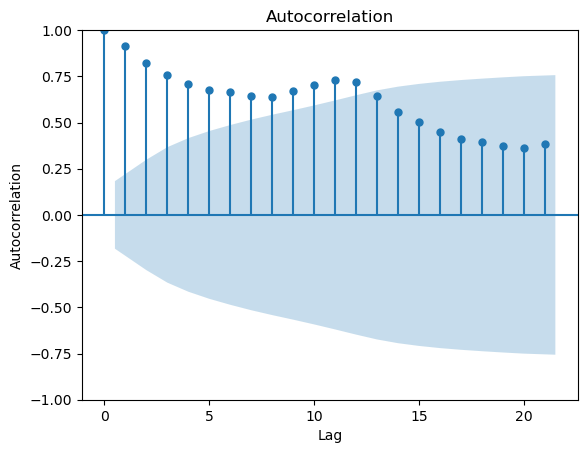

In [9]:
plot_acf(train[f'{ts_variable}'].dropna())
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.savefig("img/autocorrelation.png", dpi = 300, bbox_inches='tight')

Seasonal pattern is present, it's better to differentiate first.

Text(0, 0.5, 'Autocorrelation (Diff)')

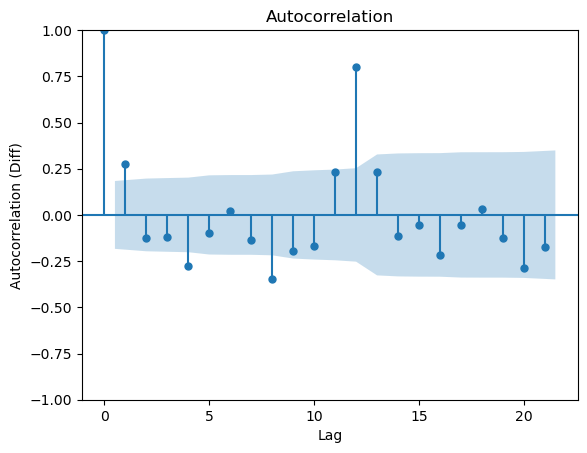

In [10]:
plot_acf(train[f'{ts_variable}'].diff().dropna())
plt.xlabel("Lag")
plt.ylabel("Autocorrelation (Diff)")

The value outside the blue region is $q=12$ and after that, all the others lags are inside the blue region. 

## Model Implementation 

In [11]:
# Arima Naive 
p = 13
d = 1
q = 12

model_naive = ARIMA(train[f"{ts_variable}"], order=(1,1,1))
model_optimal = ARIMA(train[f"{ts_variable}"], order=(p,d,q))

model_naive_fit = model_naive.fit()
model_optimal_fit = model_optimal.fit()

/opt/anaconda3/envs/data-science/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/data-science/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/data-science/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  115
Model:               ARIMA(13, 1, 12)   Log Likelihood                -416.861
Date:                Tue, 01 Oct 2024   AIC                            885.722
Time:                        11:48:15   BIC                            956.864
Sample:                             0   HQIC                           914.595
                                - 115                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3656      0.405     -0.903      0.367      -1.159       0.428
ar.L2         -0.0881      0.301     -0.293      0.770      -0.678       0.502
ar.L3          0.1064      0.285      0.373      0.7

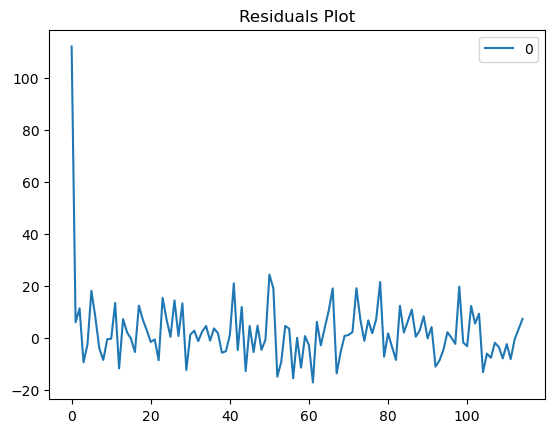

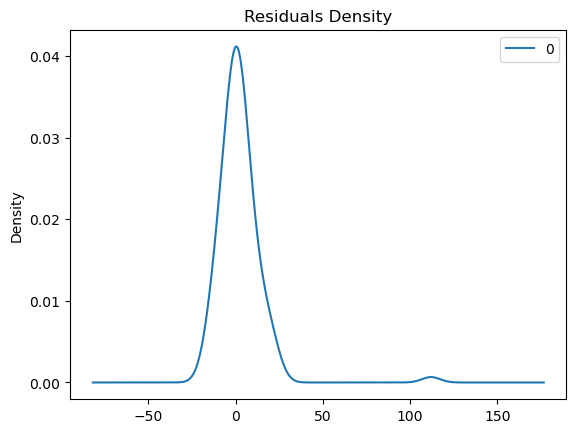

                0
count  115.000000
mean     2.325708
std     13.497794
min    -17.223169
25%     -4.399513
50%      0.687627
75%      6.780564
max    112.000000


In [12]:
# Summary of fit Model 
print(model_optimal_fit.summary())
# Residuals Plot
residuals = pd.DataFrame(model_optimal_fit.resid)
residuals.plot()
plt.title("Residuals Plot")
plt.show()
# Density plot Residuals
residuals.plot(kind='kde')
plt.title("Residuals Density")
plt.show()
# summary stats of residuals
print(residuals.describe())

In [13]:
train["prediction_optimal"] = model_optimal_fit.predict(start=0, end=len(train))
train["prediction_naive"] = model_naive_fit.predict(start=0, end=len(train))

test["prediction_optimal"] = model_optimal_fit.forecast(steps = len(test))
test["prediction_naive"] = model_naive_fit.forecast(steps = len(test))
test

,Passengers,date,prediction_optimal,prediction_naive
115,505,1958-08-01,490.382155,502.649601
116,404,1958-09-01,434.848875,496.695602
117,359,1958-10-01,377.764884,499.738634
118,310,1958-11-01,340.366469,498.183369
119,337,1958-12-01,369.365101,498.978250
120,360,1959-01-01,369.391617,498.571994
121,342,1959-02-01,345.570147,498.779628
122,406,1959-03-01,381.340719,498.673508
123,396,1959-04-01,370.539935,498.727745
124,420,1959-05-01,384.397256,498.700025


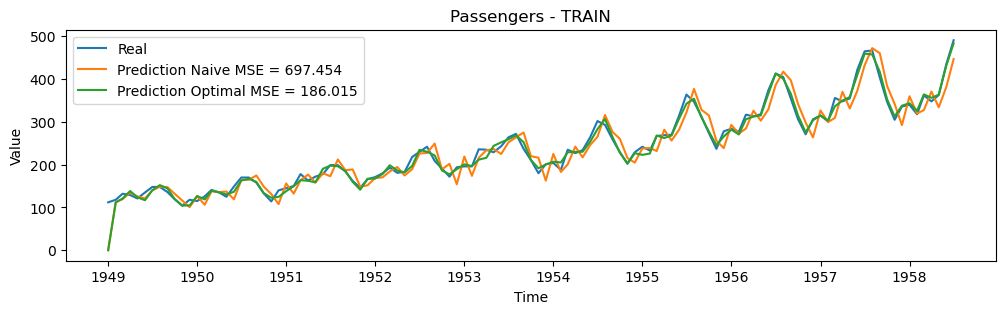

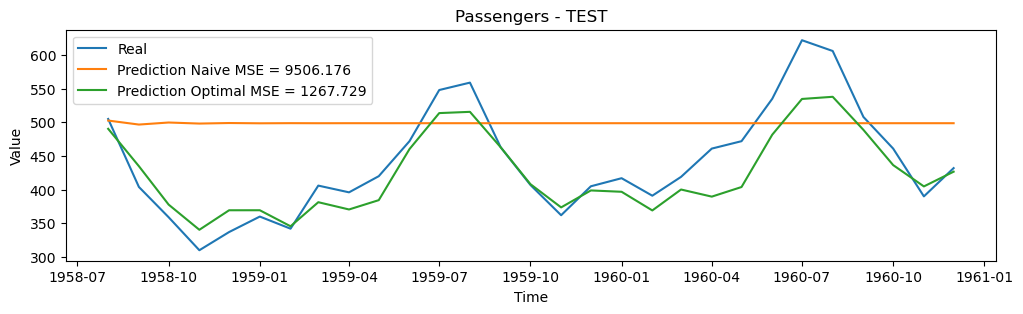

In [14]:
mse_train_naive = mean_squared_error(train[ts_variable], train['prediction_naive'])
mse_train_optimal = mean_squared_error(train[ts_variable], train['prediction_optimal'])

mse_test_naive = mean_squared_error(test[ts_variable], test['prediction_naive'])
mse_test_optimal = mean_squared_error(test[ts_variable], test['prediction_optimal'])

plt.figure(figsize=(12,3))
plt.plot(train[date_variable], train[ts_variable], label = f'Real')
plt.plot(train[date_variable], train["prediction_naive"], label = f"Prediction Naive MSE = {round(mse_train_naive,3)}")
plt.plot(train[date_variable], train["prediction_optimal"], label = f"Prediction Optimal MSE = {round(mse_train_optimal,3)}")
plt.title(f"{ts_variable} - TRAIN")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show() 

plt.figure(figsize=(12,3))
plt.plot(test[date_variable], test[ts_variable], label = f'Real')
plt.plot(test[date_variable], test["prediction_naive"], label = f"Prediction Naive MSE = {round(mse_test_naive,3)}")
plt.plot(test[date_variable], test["prediction_optimal"], label = f"Prediction Optimal MSE = {round(mse_test_optimal,3)}")
plt.title(f"{ts_variable} - TEST")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()

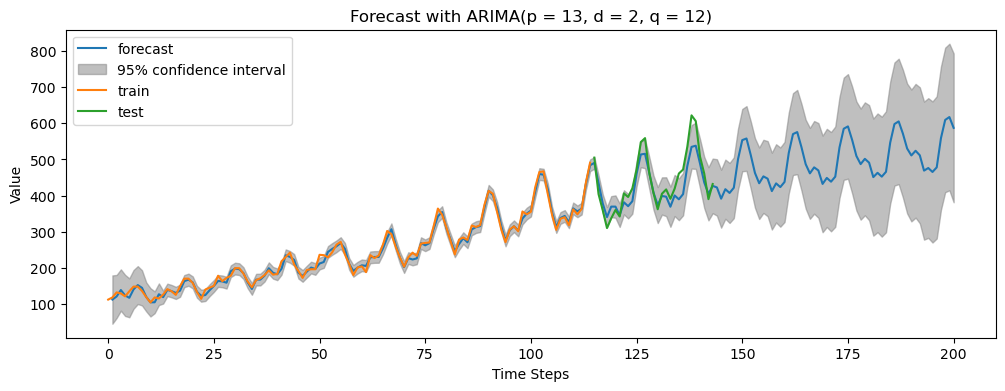

In [15]:
fig, ax = plt.subplots(figsize = (12,4))
plot_predict(model_optimal_fit, 1,200, ax = ax)
ax.plot(range(len(train[date_variable])), train[ts_variable], label = f'train')
ax.plot(range(115, 115 + len(test[date_variable])), test[ts_variable], label = f'test')
plt.legend()
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.title("Forecast with ARIMA(p = 13, d = 2, q = 12)")
plt.savefig("img/arima_results.png", dpi = 300, bbox_inches='tight')